In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pytorch3d.ops import sample_farthest_points

In [2]:
folder_path = "samples_data" # locazione della cartella in cui risiedono i campioni del Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
epochs = 100
lr = 0.001 # learning rate
train_ratio = 0.75 # percentuale campioni del Dataset che faranno parte del training set
embedding_dim = 32 # n° features dei vettori generati dall'Embedding Layer
num_layers = 2 # n° layer della GRU
hidden_size= 128 # n° features degli hidden state dei layer della GRU 
input_size = 2 # n° coordinate dei punti della traiettoria in input alla GRU (non si considera la y)
past_seconds = 2 # n° secondi che si considerano della traiettoria passata
future_seconds = 4 # n° secondi che si considerano della traiettoria futura
framerate = 10 # n° punti delle traiettorie campionati in un secondo

In [3]:
def extract_number(filename):
    return int(filename.split('_')[1].split('.')[0])

## Calcolo e salvataggio subsampling delle nuvole di punti

In [ ]:
all_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]        
npz_files = sorted(all_files, key=extract_number)

point_clouds_subsampled = [] # lista delle nuvole di punti sottocampionate

with torch.no_grad():
    for file_name in npz_files:
        file_path = os.path.join(folder_path, file_name)
        data = np.load(file_path)

        # Prende la nuvola di punti e la mette su GPU
        point_cloud = torch.tensor(data["point_cloud"], dtype=torch.float32).unsqueeze(0).to(device)

        # Calcola la nuvola di punti sottocampionata
        sampled_pc = sample_farthest_points(point_cloud, K=1024)[0].squeeze(0).cpu().numpy()

        # Aggiunge la nuvola sottocampionata alla lista
        point_clouds_subsampled.append(sampled_pc)

# Salva le nuvole sottocampionate in un file NPZ
np.savez_compressed("point_clouds_subsampled.npz", subsampling=np.array(point_clouds_subsampled))

print("Subsampled point clouds saved in 'point_clouds_subsampled.npz'!")

Subsampled point clouds saved in 'point_clouds_subsampled.npz'!


## Annotazione dei punti delle nuvole sottocampionate 

In [4]:
original_res = (376, 672) # risoluzione originale (H, W) delle immagini catturate

# matrice intrinseca K della camera per la risoluzione originale
K = np.array([
    [357.1, 0.0, 335.4],
    [0.0, 357.1, 180.2],
    [0.0, 0.0, 1.0]
])

In [5]:
import sys
sys.path.append("./Mask2Former")  # locazione di Mask2Former

from detectron2.utils.logger import setup_logger
setup_logger(name="mask2former")

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from mask2former import add_maskformer2_config

/data01/iva24alesan/miniconda3/envs/IVA/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/data01/iva24alesan/Lab_IVA/Mask2Former/mask2former/modeling/pixel_decoder/msdeformattn.py:314: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)


In [6]:
cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)

cfg.merge_from_file("Mask2Former/configs/coco/panoptic-segmentation/swin/maskformer2_swin_small_bs16_50ep.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/panoptic/maskformer2_swin_small_bs16_50ep/model_final_a407fd.pkl'
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = True
cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = False
cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = False

predictor = DefaultPredictor(cfg)

/data01/iva24alesan/miniconda3/envs/IVA/lib/python3.13/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


WARNING [09/27 15:21:05 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


In [7]:
# Scala la matrice intrinseca K dalla risoluzione originale a quella corrente

def scale_intrinsic_matrix(K, original_res, current_res):
    orig_h, orig_w = original_res
    curr_h, curr_w = current_res

    scale_x = curr_w / orig_w
    scale_y = curr_h / orig_h

    K_scaled = K.copy()
    K_scaled[0, 0] *= scale_x  # fx
    K_scaled[0, 2] *= scale_x  # cx
    K_scaled[1, 1] *= scale_y  # fy
    K_scaled[1, 2] *= scale_y  # cy

    return K_scaled

In [8]:
# Proietta una nuvola di punti nell'immagine RGB usando la matrice intrinseca K

def project_points_to_image(pc, K):

    # Estrae i singoli assi
    X, Y, Z = pc[:, 0], pc[:, 1], pc[:, 2]
    valid_mask = Z > 0  # considera solo i punti davanti alla camera

    X, Y, Z = X[valid_mask], Y[valid_mask], Z[valid_mask]

    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    u = (X * fx / Z + cx).astype(int)
    v = (Y * fy / Z + cy).astype(int)

    valid_pixels = np.stack([u, v], axis=1)
    valid_indices = np.where(valid_mask)[0]

    return valid_pixels, valid_indices

In [9]:
# Annota ciascun punto della nuvola concatenando alle coordinate spaziali l'indice della classe del rispettivo
# pixel nell'immagine RGB. La nuvola di punti, quindi, da dimensione [N, 3] passerà a dimensione [N, 4]

def annotate_point_cloud_with_semantics(pc, sem_seg, K, original_res, current_res):
    pc_np = pc.numpy()
    
    # Scala, se necessario, la matrice intrinseca
    K_scaled = scale_intrinsic_matrix(K, original_res, current_res)

    # Usa la funzione di proiezione
    valid_pixels, valid_indices = project_points_to_image(pc_np, K_scaled)

    H, W = sem_seg.shape
    u, v = valid_pixels[:, 0], valid_pixels[:, 1]

    # Maschera per filtrare i pixel proiettati che cadono fuori dall'immagine
    inside_mask = (u >= 0) & (u < W) & (v >= 0) & (v < H)

    class_indices = np.full(len(pc_np), -1, dtype=np.int32)  # default -1
    valid_inside_indices = valid_indices[inside_mask]
    class_indices[valid_inside_indices] = sem_seg[v[inside_mask], u[inside_mask]]

    # Concatenazione come tensore PyTorch
    annotated_pc = torch.cat([
        pc,
        torch.tensor(class_indices, dtype=torch.float32).unsqueeze(1)
    ], dim=1)

    return annotated_pc


In [10]:
all_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]        
npz_files = sorted(all_files, key=extract_number)

# Carica le nuvole di punti sottocampionate
loaded_pc_subsampled = np.load("point_clouds_subsampled.npz")
point_clouds_subsampled = [subsampling for subsampling in loaded_pc_subsampled["subsampling"]]

# Carica le immagini RGB
loaded_images = [np.load(os.path.join(folder_path, f))["rgb_frame"] for f in npz_files]

image_maps = []

for rgb_image in loaded_images:
    rgb_image = np.flipud(rgb_image) # prende l'immagine e la mette sopra-sotto
    bgr_image = rgb_image[:, :, ::-1] # conversione dell'immagine da RGB a BGR

    with torch.no_grad():  
        outputs = predictor(bgr_image)
    sem_seg = outputs["sem_seg"].argmax(dim=0) #mappa 2D dove ogni pixel ha un valore intero corrispondente all’indice 
                                               #della classe predetta
    sem_seg = sem_seg.cpu().numpy() # NON ricapovolge la mappa semantica

    image_maps.append(sem_seg)

In [11]:
annotated_point_clouds = []

#Annota tutte le nuvole di punti sottocampionate
for pc, sem_seg in zip(point_clouds_subsampled, image_maps):
    pc_tensor = torch.tensor(pc, dtype=torch.float32)    

    annotated_pc = annotate_point_cloud_with_semantics(
        pc_tensor,
        sem_seg,
        K=K, 
        original_res=(376, 672),
        current_res=sem_seg.shape
    )

    annotated_point_clouds.append(annotated_pc.numpy())

# Salva tutte le nuvole di punti annotate in un unico file .npz
np.savez_compressed(
    "point_clouds_subsampled_annotated.npz",
    annotated_subsampling=np.stack(annotated_point_clouds)
)

print("Annotated subsampled point clouds saved in 'point_clouds_subsampled_annotated.npz'!")

Annotated subsampled point clouds saved in 'point_clouds_subsampled_annotated.npz'!


In [12]:
# Funzione per visualizzare un'immagine con sopra i punti della rispettiva nuvola proiettati

def visualize_annotated_projection_on_image(rgb_image, annotated_pc, K, original_res, current_res, class_colors=None):
    # Separa coordinate 3D e classi
    coords = annotated_pc[:, :3]
    class_ids = annotated_pc[:, 3].astype(int)

    # Scala, se necessario, la matrice intrinseca
    K_scaled = scale_intrinsic_matrix(K, original_res, current_res)

    # Proiezione dei punti della nuvola sull'immagine
    projected_pixels, valid_indices = project_points_to_image(coords, K_scaled)

    H, W, _ = rgb_image.shape
    u, v = projected_pixels[:, 0], projected_pixels[:, 1]

    # Filtra i punti dentro l'immagine
    inside_mask = (u >= 0) & (u < W) & (v >= 0) & (v < H)
    u, v = u[inside_mask], v[inside_mask]
    valid_class_ids = class_ids[valid_indices][inside_mask]

    # Mappa classi → colori (se non fornita)
    if class_colors is None:
        num_classes = valid_class_ids.max() + 1
        cmap = plt.cm.get_cmap('tab20', num_classes)
        class_colors = [cmap(i) for i in range(num_classes)]

    # Ottiene i colori
    point_colors = [class_colors[i] if i >= 0 else (0, 0, 0, 0.5) for i in valid_class_ids]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(np.flipud(rgb_image))
    plt.scatter(u, v, c=point_colors, s=2)
    plt.title("An image with the cloud points projected")
    plt.axis('off')
    plt.show()


/tmp/ipykernel_104307/4012935824.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


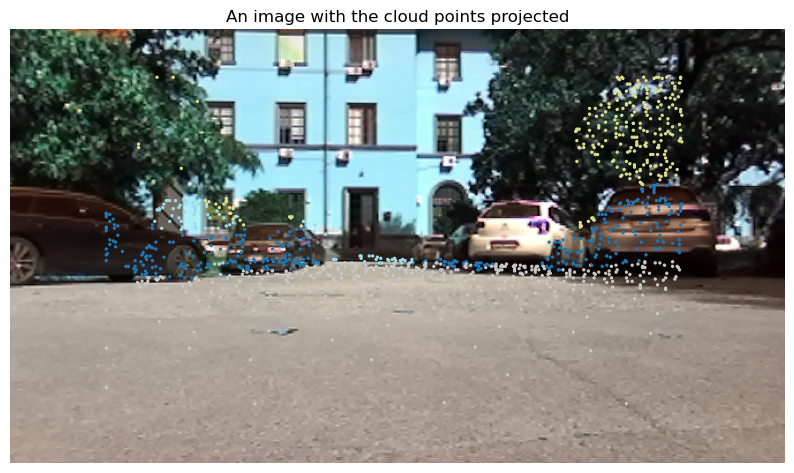

In [13]:
all_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]        
npz_files = sorted(all_files, key=extract_number)

# Carica le nuvole di punti annotate e le immagini. Prende poi una nuvola con la rispettiva immagine, e richiama la 
# funzione per visualizzare l'immagine con i punti della nuvola proiettati

annotated_data = np.load("point_clouds_subsampled_annotated.npz", allow_pickle=True)
annotated_point_clouds = annotated_data["annotated_subsampling"]
loaded_images = [np.load(os.path.join(folder_path, f))["rgb_frame"] for f in npz_files]

idx = 0  # indice del frame da visualizzare

annotated_pc = annotated_point_clouds[idx]
rgb_image = loaded_images[idx]

visualize_annotated_projection_on_image(
    rgb_image=rgb_image,
    annotated_pc=annotated_pc,
    K=K,
    original_res=(376, 672),
    current_res=rgb_image.shape[:2]
)


## Sezione addestramento del modello

In [4]:
class PointNetfeat(nn.Module):
    def __init__(self, embedding_dim):
        super(PointNetfeat, self).__init__()
        self.conv1 = torch.nn.Conv1d(3+embedding_dim, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        return x

In [5]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, point_clouds_annotated, past_seconds=2, future_seconds=4, framerate=10,
                  train_ratio=0.75, mode='all'):
        self.folder_path = folder_path
        self.past_frames = framerate * past_seconds
        self.future_frames = framerate * future_seconds
        self.point_clouds_annotated = point_clouds_annotated
        self.train_ratio = train_ratio
        self.mode = mode

        def extract_number(filename):
            return int(filename.split('_')[1].split('.')[0])

        all_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]
        all_files_sorted = sorted(all_files, key=extract_number)

        split_index = int(len(all_files_sorted) * train_ratio) # indice di separazione tra training e test set

        if mode == "train":
            self.npz_files = all_files_sorted[:split_index]
            self.point_clouds_annotated = point_clouds_annotated[:split_index]
        elif mode == "test":
            self.npz_files = all_files_sorted[split_index:]
            self.point_clouds_annotated = point_clouds_annotated[split_index:]
        else:
            self.npz_files = all_files_sorted
            self.point_clouds_annotated = point_clouds_annotated


    def __len__(self):
        return len(self.npz_files)

    def local_smoothing(self, future_traj, iterations=1): # funzione che esegue lo smoothing locale
                                                          # della traiettoria futura
        smoothed_traj = future_traj.clone()

        for _ in range(iterations):
            temp_traj = smoothed_traj.clone()

            prev_points = temp_traj[:-2]
            current_points = temp_traj[1:-1]
            next_points = temp_traj[2:]

            smoothed_traj[1:-1] = 0.25*prev_points + 0.5*current_points + 0.25*next_points   
        
        return smoothed_traj

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, self.npz_files[idx])
        data = np.load(file_path)

        # Converte le traiettorie (senza la coordinata y) e la nuvola in tensori PyTorch
        past_trajectory = torch.tensor(np.delete(data["past_trajectory"], 1, 1), dtype=torch.float32)
        future_trajectory = torch.tensor(np.delete(data["future_trajectory"], 1, 1), dtype=torch.float32)
        point_clouds_annotated = (self.point_clouds_annotated[idx])

        past_trajectory = past_trajectory[:self.past_frames]
        future_trajectory = future_trajectory[:self.future_frames]

        past_trajectory = torch.flip(past_trajectory, [0]) # Inverte la traiettoria passata in modo che
                                                           # inizi dal punto più lontano nel tempo e termini
                                                           # con quello presente (0, 0)

        if(self.mode == "train"): # Data Augmentation
            if(np.random.rand() < 0.5):
                # smoothing locale della traiettoria futura
                n_iterations = np.random.randint(1, 3)
                future_trajectory = self.local_smoothing(future_trajectory, iterations=n_iterations)

            if np.random.rand() < 0.5:
                # flip orizzontale di tutta la traiettoria e dei punti della nuvola
                past_trajectory[:, 0] *= -1
                future_trajectory[:, 0] *= -1
                point_clouds_annotated[:, 0] *= -1    


        return past_trajectory, future_trajectory, point_clouds_annotated

In [6]:
class AutoregressiveModel(nn.Module):
    def __init__(self, class_to_emb_idx, embedding_dim=32, input_size=2, hidden_size=128, output_size=2, 
                 num_layers=2, future_steps=40):
        super(AutoregressiveModel, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.future_steps = future_steps
        self.class_to_emb_idx = class_to_emb_idx
        self.embedding_dim = embedding_dim
        self.class_mapping = torch.full((max(class_to_emb_idx.keys()) + 1,), -1, dtype=torch.long)
        for cl, idx in class_to_emb_idx.items():
            self.class_mapping[cl] = idx
        
        self.embedding_layer = nn.Embedding(num_embeddings=len(self.class_to_emb_idx), 
                                            embedding_dim=self.embedding_dim)
        self.pointnet = PointNetfeat(embedding_dim=self.embedding_dim)
        self.pc_emb_proj = nn.Linear(1024, self.hidden_size)
        self.pc_emb_norm = nn.LayerNorm(self.hidden_size)
        self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers, dropout=0.3, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, past, point_clouds):
        all_coord = point_clouds[:, :, :3]
        all_classes = point_clouds[:, :, 3].long()
        mapped_indices = self.class_mapping.to(past.device)[all_classes]
        all_idx_emb = self.embedding_layer(mapped_indices)
        new_point_clouds = torch.cat((all_coord, all_idx_emb), dim=2)
        
        new_point_clouds_emb = self.pointnet(new_point_clouds)
        new_point_clouds_emb = self.pc_emb_norm(self.pc_emb_proj(new_point_clouds_emb))

        h0 = new_point_clouds_emb.unsqueeze(0).repeat(self.num_layers, 1, 1).to(past.device)
        
        out, h = self.gru(past[:, :-1, :], h0) # out contiene tutti gli hidden state (dell'ultimo layer della GRU)
                                               # di tutta la sequenza (ultimo punto escluso) ed ha quindi
                                               # dimensione [batch_size, seq_length-1, hidden_dim]
                                               # h contiene l'ultimo hidden state della sequenza di ogni layer
                                               # della GRU, ed ha dimensione [num_layers, batch_size, hidden_dim]
        
        future_trajectory_pred = []
        last_input = past[:, -1, :]  # ultimo punto della traiettoria passata ([batch_size, input_size])

        for _ in range(self.future_steps): 
            last_input = last_input.unsqueeze(1) #la dimensione ora è [batch_size, 1, input_size]
            out, h = self.gru(last_input, h)
            future_point = self.fc(out.squeeze(1)) # predizione punto successivo
            future_trajectory_pred.append(future_point)
            last_input = future_point # il punto successivo predetto diventa l'ultimo input
             
        return torch.stack(future_trajectory_pred, dim=1)

In [7]:
class OneShotModel(nn.Module):
    def __init__(self, class_to_emb_idx, embedding_dim=32, input_size=2, hidden_size=128, output_size=2*40, 
                 num_layers=2, future_steps=40):
        super(OneShotModel, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.future_steps = future_steps
        self.class_to_emb_idx = class_to_emb_idx
        self.embedding_dim = embedding_dim
        self.class_mapping = torch.full((max(class_to_emb_idx.keys()) + 1,), -1, dtype=torch.long)
        for cl, idx in class_to_emb_idx.items():
            self.class_mapping[cl] = idx

        self.embedding_layer = nn.Embedding(num_embeddings=len(self.class_to_emb_idx), 
                                            embedding_dim=self.embedding_dim)
        self.pointnet = PointNetfeat(embedding_dim=self.embedding_dim)
        self.pc_emb_proj = nn.Linear(1024, self.hidden_size)
        self.pc_emb_norm = nn.LayerNorm(self.hidden_size)
        self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers, dropout=0.3, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, past, point_clouds):
        all_coord = point_clouds[:, :, :3]
        all_classes = point_clouds[:, :, 3].long()
        mapped_indices = self.class_mapping.to(past.device)[all_classes]
        all_idx_emb = self.embedding_layer(mapped_indices)
        new_point_clouds = torch.cat((all_coord, all_idx_emb), dim=2)
        
        new_point_clouds_emb = self.pointnet(new_point_clouds)
        new_point_clouds_emb = self.pc_emb_norm(self.pc_emb_proj(new_point_clouds_emb))

        h0 = new_point_clouds_emb.unsqueeze(0).repeat(self.num_layers, 1, 1).to(past.device)
        
        _, h = self.gru(past, h0) # out contiene tutti gli hidden state (dell'ultimo layer della GRU) di tutta la
                                  # sequenza ed ha quindi dimensione [batch_size, seq_length, hidden_dim]
                                  # h contiene l'ultimo hidden state della sequenza di ogni layer della GRU, ed ha
                                  # dimensione [num_layers, batch_size, hidden_dim]
        
        last_hidden = h[-1]  # [batch_size, hidden_size]
        future_points = self.fc(last_hidden)  # [batch_size, 2*future_steps]
        future_points = future_points.view(past.size(0), self.future_steps, self.input_size)
             
        return future_points

In [8]:
def train(model, device, train_loader, optimizer, future_x_std, future_z_std):
    model.train() # setta il modello in training mode
    
    lambda_x = 1./future_x_std
    lambda_z = 1./future_z_std
    
    train_mse_x = 0
    train_mse_z = 0
    train_mse_total = 0
    total_samples = 0

    for past, future, pc in train_loader: # iterazione sui batch
        past, future, pc = past.to(device), future.to(device), pc.to(device) #spostamento dati sulla GPU
        optimizer.zero_grad() #azzera i gradienti

        future_pred = model(past, pc) #viene eseguito il forward

        #calcolo delle loss, con la somma per normalizzare
        loss_x = F.mse_loss(future_pred[:, :, 0], future[:, :, 0], reduction='sum') # MSE su x
        loss_z = F.mse_loss(future_pred[:, :, -1], future[:, :, -1], reduction='sum') # MSE su z
        loss_total = lambda_x * loss_x + lambda_z * loss_z   
        
        train_mse_x += loss_x.item()
        train_mse_z += loss_z.item()
        train_mse_total += loss_total.item()

        loss_total.backward() # calcola i gradienti
        optimizer.step() # aggiorna i pesi

        total_samples += future.size(0) * future.size(1)  # numero totale di punti della traiettoria

    # normalizzazione per ottenere la media
    train_mse_x /= total_samples
    train_mse_z /= total_samples
    train_mse_total /= total_samples

    print(f'Train: MSE Total = {train_mse_total:.6f},  MSE X = {train_mse_x:.6f},  MSE Z = {train_mse_z:.6f}')
    
    return train_mse_total, train_mse_x, train_mse_z

In [9]:
def test(model, device, test_loader, future_x_std, future_z_std):
    model.eval() #setta il modello in evaluation mode
    
    lambda_x = 1./future_x_std
    lambda_z = 1./future_z_std
    
    test_mse_x, test_mse_z, test_mse_total = 0, 0, 0
    total_samples = 0

    with torch.no_grad():
        for past, future, pc in test_loader:
            past, future, pc = past.to(device), future.to(device), pc.to(device)
            future_pred = model(past, pc)

            loss_x = F.mse_loss(future_pred[:, :, 0], future[:, :, 0], reduction='sum')  # MSE su x
            loss_z = F.mse_loss(future_pred[:, :, -1], future[:, :, -1], reduction='sum')  # MSE su z
            loss_total = lambda_x * loss_x + lambda_z * loss_z  
            
            test_mse_x += loss_x.item()
            test_mse_z += loss_z.item()
            test_mse_total += loss_total.item()

            total_samples += future.size(0) * future.size(1)

    # normalizzazione per ottenere la media
    test_mse_x /= total_samples
    test_mse_z /= total_samples
    test_mse_total /= total_samples

    print(f'Test:  MSE Total = {test_mse_total:.6f},  MSE X = {test_mse_x:.6f},  MSE Z = {test_mse_z:.6f}')
    return test_mse_total, test_mse_x, test_mse_z

In [10]:
def fit(model, device, train_loader, test_loader, optimizer, epochs, future_x_std, future_z_std):

    best_weights = copy.deepcopy(model.state_dict())
    best_epoch = 0
    best_test_loss = float("inf")

    train_losses_x = []
    train_losses_z = []
    train_losses_total = []
    test_losses_x = []
    test_losses_z = []
    test_losses_total = []

    start_time = time.time()

    for epoch in range(1, epochs + 1):
        #esegue un'epoca di training
        print(f"Epoch {epoch}")
        train_loss_total, train_loss_x, train_loss_z = train(model, device, train_loader, optimizer,
                                                            future_x_std, future_z_std)
        test_loss_total, test_loss_x, test_loss_z = test(model, device, test_loader, future_x_std, future_z_std)

        if(test_loss_total < best_test_loss):
            best_epoch = epoch
            best_test_loss = test_loss_total
            best_weights = copy.deepcopy(model.state_dict()) 

        train_losses_total.append(train_loss_total)
        train_losses_x.append(train_loss_x)
        train_losses_z.append(train_loss_z)
        test_losses_total.append(test_loss_total)
        test_losses_x.append(test_loss_x)
        test_losses_z.append(test_loss_z)
        print()

    model.load_state_dict(best_weights)
    print(f"Got the weights of the epoch {best_epoch}")

    end_time = time.time()

    execution_time = end_time - start_time

    minutes, seconds = divmod(execution_time, 60) #converte il tempo in minuti e secondi

    print(f"Execution time: {int(minutes)} minutes, {seconds:.2f} seconds")

    return {
        "train_losses": {
            "total": train_losses_total,
            "x": train_losses_x,
            "z": train_losses_z
        },
        "test_losses": {
            "total": test_losses_total,
            "x": test_losses_x,
            "z": test_losses_z
        }
    }

In [11]:
def plot_loss(epochs, history):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 riga, 3 colonne

    # Plot per la loss totale
    axes[0].plot(range(1, epochs + 1), history["train_losses"]["total"], marker='o', color='red', label="Train Total loss")
    axes[0].plot(range(1, epochs + 1), history["test_losses"]["total"], marker='o', color='blue', label="Test Total loss")
    axes[0].set_xticks([1] + list(range(10, epochs + 1, 10)))
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].set_title('Total Loss')

    # Plot per la loss su X
    axes[1].plot(range(1, epochs + 1), history["train_losses"]["x"], marker='o', color='red', label="Train X loss")
    axes[1].plot(range(1, epochs + 1), history["test_losses"]["x"], marker='o', color='blue', label="Test X loss")
    axes[1].set_xticks([1] + list(range(10, epochs + 1, 10)))
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].set_title('X Loss')

    # Plot per la loss su Z
    axes[2].plot(range(1, epochs + 1), history["train_losses"]["z"], marker='o', color='red', label="Train Z loss")
    axes[2].plot(range(1, epochs + 1), history["test_losses"]["z"], marker='o', color='blue', label="Test Z loss")
    axes[2].set_xticks([1] + list(range(10, epochs + 1, 10)))
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].set_title('Z Loss')

    plt.tight_layout()  # Per evitare sovrapposizioni
    plt.show()

In [12]:
# Carica le nuvole di punti sottocampionate e annotate, e crea un lista contenente i rispettivi tensori
loaded_pc_annotated = np.load("point_clouds_subsampled_annotated.npz")
point_clouds_annotated = [torch.tensor(pc, dtype=torch.float32) for pc in 
                           loaded_pc_annotated["annotated_subsampling"]]


# Istanziamento del Dataset completo e del training e test set con i rispettivi DataLoader

original_dataset = CustomDataset(folder_path=folder_path, point_clouds_annotated=point_clouds_annotated, 
                        past_seconds=past_seconds, future_seconds=future_seconds, framerate=framerate, mode="all")

train_set = CustomDataset(folder_path=folder_path, point_clouds_annotated=point_clouds_annotated, 
                        past_seconds=past_seconds, future_seconds=future_seconds, framerate=framerate, 
                        train_ratio=train_ratio, mode="train")

test_set = CustomDataset(folder_path=folder_path, point_clouds_annotated=point_clouds_annotated, 
                        past_seconds=past_seconds, future_seconds=future_seconds, framerate=framerate, 
                        train_ratio=train_ratio, mode="test")

train_loader = DataLoader(train_set, num_workers=2, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, num_workers=2, batch_size=batch_size, shuffle=False)

In [13]:
for past, future, pc in train_loader:
    print(past.shape)
    print(future.shape)
    print(pc.shape)
    break

torch.Size([64, 20, 2])
torch.Size([64, 40, 2])
torch.Size([64, 1024, 4])


In [13]:
#Prende tutte le classi valide dei punti delle nuvole di e costruisce un dizionario dove le chiavi sono le classi e
#i valori rappresentano i rispettivi indici 

all_classes = set()

for _, _, pc in original_dataset:
    pc_annotations = pc[:, 3].tolist()
    valid_classes = [int(c) for c in pc_annotations if c >= 0]
    all_classes.update(valid_classes)

all_classes = list(all_classes)
all_classes.sort()
num_embeddings = len(all_classes)
class_to_emb_idx = {cl : i for i, cl in enumerate(all_classes)}

In [14]:
#Calcolo della varianza e della deviazione standard globali di x e di z nel futuro

all_x_values = []
all_z_values = []

for _, future, _ in original_dataset:
    all_x_values.append(future[:, 0])
    all_z_values.append(future[:, 1])

#Concatenazione di tutti i punti
all_x_values = torch.cat(all_x_values)
all_z_values = torch.cat(all_z_values)

future_x_var = torch.var(all_x_values)
future_z_var = torch.var(all_z_values)

future_x_std = future_x_var ** 0.5
future_z_std = future_z_var ** 0.5

print(f"Global variance of the future x-coordinate: {future_x_var.item()}")
print(f"Global variance of the future z-coordinate: {future_z_var.item()}")

Global variance of the future x-coordinate: 0.5222423076629639
Global variance of the future z-coordinate: 2.0641021728515625


In [ ]:
batch = next(iter(test_loader))  # Prende un batch dal test_loader
past_batch, future_batch, _ = batch

for points in past_batch:
    print(points.shape)
    print(points[0])


for i in range(2):  # Plotta solo 2 esempi
    past = past_batch[i].numpy()
    future = future_batch[i].numpy()

    plt.figure(figsize=(5, 5))
    plt.plot(past[:, 0], past[:, 1], 'go-', label='Past Trajectory')
    plt.plot(future[:, 0], future[:, 1], 'ro-', label='Future Trajectory')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.legend()
    plt.title(f"Sample {i+1}")
    plt.show()

In [16]:
# Istanziamento e fitting del modello autoregressivo

autoregressive_model = AutoregressiveModel(class_to_emb_idx=class_to_emb_idx, embedding_dim=embedding_dim,
                                           input_size=input_size, hidden_size=hidden_size, 
                                           output_size=input_size, num_layers=num_layers, 
                                           future_steps=future_seconds*framerate).to(device)

autoregressive_optimizer = optim.Adam(autoregressive_model.parameters(), lr=lr, weight_decay=1e-5)

print("Fitting autoregressive model:\n")
autoregressive_history = fit(autoregressive_model, device, train_loader, test_loader, 
                             autoregressive_optimizer, epochs, future_x_std, future_z_std)

Fitting autoregressive model:

Epoch 1
Train: MSE Total = 1.760341,  MSE X = 0.567584,  MSE Z = 1.400687
Test:  MSE Total = 0.842612,  MSE X = 0.443281,  MSE Z = 0.329311

Epoch 2
Train: MSE Total = 0.982253,  MSE X = 0.558664,  MSE Z = 0.300544
Test:  MSE Total = 0.743640,  MSE X = 0.443429,  MSE Z = 0.186823

Epoch 3
Train: MSE Total = 0.935348,  MSE X = 0.555813,  MSE Z = 0.238825
Test:  MSE Total = 0.745751,  MSE X = 0.446943,  MSE Z = 0.182869

Epoch 4
Train: MSE Total = 0.914035,  MSE X = 0.554955,  MSE Z = 0.209909
Test:  MSE Total = 0.719658,  MSE X = 0.446350,  MSE Z = 0.146562

Epoch 5
Train: MSE Total = 0.898871,  MSE X = 0.556547,  MSE Z = 0.184958
Test:  MSE Total = 0.713796,  MSE X = 0.452486,  MSE Z = 0.125939

Epoch 6
Train: MSE Total = 0.900403,  MSE X = 0.556762,  MSE Z = 0.186732
Test:  MSE Total = 0.707807,  MSE X = 0.443341,  MSE Z = 0.135516

Epoch 7
Train: MSE Total = 0.892264,  MSE X = 0.555295,  MSE Z = 0.177954
Test:  MSE Total = 0.725804,  MSE X = 0.452280,  

Autoregressive model losses:


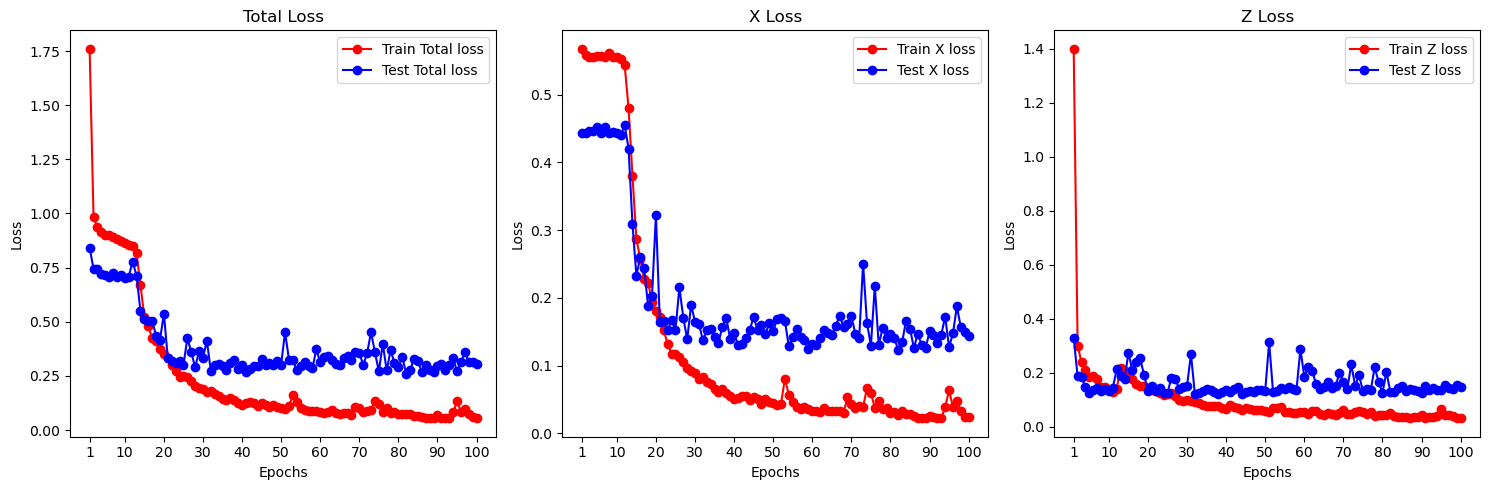

In [17]:
# Plot delle loss del modello autoregressivo

print("Autoregressive model losses:")
plot_loss(epochs, autoregressive_history)

In [17]:
# Salvataggio pesi del modello autoregressivo

torch.save(autoregressive_model.state_dict(), "pred_from_past_and_pc_sem_autoreg_model")
print("Autoregressive model weights saved in 'pred_from_past_and_pc_sem_autoreg_model'!")

Autoregressive model weights saved in 'pred_from_past_and_pc_sem_autoreg_model'!


In [16]:
# Istanziamento e fitting del modello one shot

one_shot_model = OneShotModel(class_to_emb_idx=class_to_emb_idx, embedding_dim=embedding_dim,
                              input_size=input_size, hidden_size=hidden_size, 
                              output_size=input_size*future_seconds*framerate, num_layers=num_layers, 
                              future_steps=future_seconds*framerate).to(device)

one_shot_optimizer = optim.Adam(one_shot_model.parameters(), lr=lr, weight_decay=1e-5)

print("Fitting one shot model:\n")
one_shot_history = fit(one_shot_model, device, train_loader, test_loader, one_shot_optimizer, epochs, 
                       future_x_std, future_z_std)

Fitting one shot model:

Epoch 1
Train: MSE Total = 2.080842,  MSE X = 0.562419,  MSE Z = 1.871418
Test:  MSE Total = 0.753751,  MSE X = 0.458045,  MSE Z = 0.172293

Epoch 2
Train: MSE Total = 0.879070,  MSE X = 0.530016,  MSE Z = 0.209255
Test:  MSE Total = 0.839656,  MSE X = 0.419609,  MSE Z = 0.372123

Epoch 3
Train: MSE Total = 0.710763,  MSE X = 0.386959,  MSE Z = 0.251854
Test:  MSE Total = 0.521321,  MSE X = 0.278307,  MSE Z = 0.195689

Epoch 4
Train: MSE Total = 0.543077,  MSE X = 0.270403,  MSE Z = 0.242660
Test:  MSE Total = 0.405033,  MSE X = 0.202073,  MSE Z = 0.180177

Epoch 5
Train: MSE Total = 0.493254,  MSE X = 0.251635,  MSE Z = 0.208392
Test:  MSE Total = 0.352271,  MSE X = 0.182632,  MSE Z = 0.143024

Epoch 6
Train: MSE Total = 0.420486,  MSE X = 0.212309,  MSE Z = 0.182030
Test:  MSE Total = 0.359400,  MSE X = 0.187954,  MSE Z = 0.142686

Epoch 7
Train: MSE Total = 0.396262,  MSE X = 0.200344,  MSE Z = 0.171014
Test:  MSE Total = 0.389864,  MSE X = 0.188338,  MSE Z 

One shot model losses:


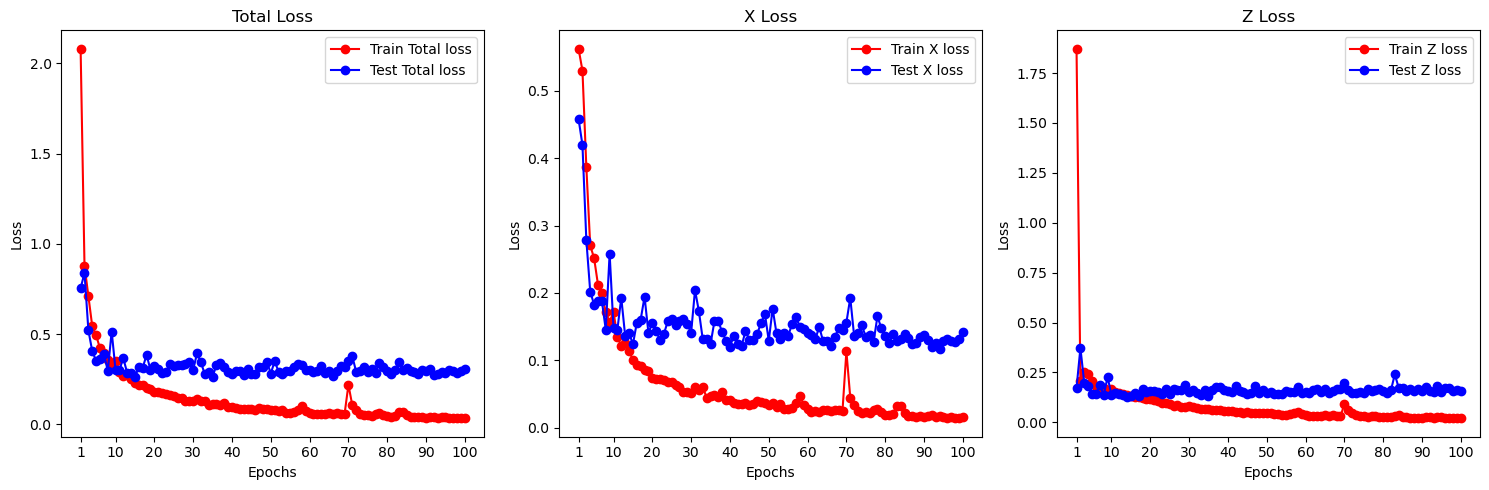

In [17]:
# Plot delle loss del modello one shot

print("One shot model losses:")
plot_loss(epochs, one_shot_history)

In [18]:
# Salvataggio pesi del modello one shot

torch.save(one_shot_model.state_dict(), "pred_from_past_and_pc_sem_oneshot_model")
print("One shot model weights saved in 'pred_from_past_and_pc_sem_oneshot_model'!")

One shot model weights saved in 'pred_from_past_and_pc_sem_oneshot_model'!


## Evaluation

In [19]:
# Funzione che seleziona alcune traiettorie dal test set e le plott­a insieme alle traiettorie future predette
# dal modello

def evaluate_trajectories(model, device, test_loader):

    model.eval()

    examples = []
    batch_indices = 6   # numero batch consecutivi usati
    example_index = [9, 9, 9, 0, 5, 50]

    # Itera sui primi 6 batch del test_loader
    for b_idx, batch in enumerate(test_loader):
        if b_idx >= batch_indices:
            break

        past_batch, future_batch, pc_batch = batch
        
        examples.append((past_batch[example_index[b_idx]], future_batch[example_index[b_idx]], 
                         pc_batch[example_index[b_idx]]))

    examples[3], examples[4], examples[5] = examples[4], examples[5], examples[3]    

    _, axes = plt.subplots(2, 3, figsize=(15, 10))

    for i, (past, future, pc) in enumerate(examples):
        
        all_points = torch.cat((past, future), 0)
        past_np = past.cpu().numpy()
        future_np = future.cpu().numpy()

        # Predizione del modello
        past_tensor = past.unsqueeze(0).to(device)  # prende un campione e aggiunge batch dim
        pc_tensor = pc.unsqueeze(0).to(device)
        with torch.no_grad():
            predicted_future = model(past_tensor, pc_tensor).squeeze(0).cpu().detach().numpy() # predice e 
                                                                                               # converte in numpy

        row, col = divmod(i, 3)  # Converte i in (riga, colonna)

        # Plot
        axes[row, col].plot(past_np[:, 0], past_np[:, 1], 'g-o', label="Past Trajectory") 
        axes[row, col].plot(future_np[:, 0], future_np[:, 1], 'r-o', label="Real Future Trajectory") 
        axes[row, col].plot(predicted_future[:, 0], predicted_future[:, 1], 'm-o', label="Predicted Future Trajectory")
        
        axes[row, col].set_xlabel("X")
        axes[row, col].set_ylabel("Z")
        axes[row, col].set_title(f"Case {i+1}")
        axes[row, col].legend()
        axes[row, col].grid()

        x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
        z_min, z_max = all_points[:, 1].min(), all_points[:, 1].max()
        
        x_min_tick = float(np.floor(float(x_min)))
        x_max_tick = float(np.ceil(float(x_max)))
        z_min_tick = float(np.floor(float(z_min)))
        z_max_tick = float(np.ceil(float(z_max)))

        axes[row, col].set_xticks(np.arange(x_min_tick, x_max_tick + 0.5, 0.5))
        axes[row, col].set_yticks(np.arange(z_min_tick, z_max_tick + 1.0, 1.0))

    plt.tight_layout()
    plt.show()

In [20]:
# Funzione che calcola e printa ADE e FDE del modello sul train e sul test set

def performance_measurement(model, device, train_loader, test_loader, label=''):
    model.eval() #setta il modello in evaluation mode
    
    train_ade_x, train_ade_z, train_ade_total = 0, 0, 0
    train_fde_x, train_fde_z, train_fde_total = 0, 0, 0
    test_ade_x, test_ade_z, test_ade_total = 0, 0, 0
    test_fde_x, test_fde_z, test_fde_total = 0, 0, 0
    total_samples = 0

    # Misurazione performance sul train set

    with torch.no_grad():
        for past, future, pc in train_loader:
            past, future, pc = past.to(device), future.to(device), pc.to(device)
            future_pred = model(past, pc)

            ade_x = torch.abs(future_pred[:, :, 0] - future[:, :, 0]).sum()
            ade_z = torch.abs(future_pred[:, :, -1] - future[:, :, -1]).sum()
            ade_total = torch.norm(future_pred - future, dim=2).sum()

            fde_x = torch.abs(future_pred[:, -1, 0] - future[:, -1, 0]).sum()
            fde_z = torch.abs(future_pred[:, -1, -1] - future[:, -1, -1]).sum()
            fde_total = torch.norm(future_pred[:, -1, :] - future[:, -1, :], dim=1).sum()
            
            train_ade_x += ade_x.item()
            train_ade_z += ade_z.item()
            train_ade_total += ade_total.item()

            train_fde_x += fde_x.item()
            train_fde_z += fde_z.item()
            train_fde_total += fde_total.item()

            total_samples += future.size(0) * future.size(1)

    train_ade_x /= total_samples
    train_ade_z /= total_samples
    train_ade_total /= total_samples

    train_fde_x /= len(train_loader.dataset)
    train_fde_z /= len(train_loader.dataset)
    train_fde_total /= len(train_loader.dataset)

    print(f'{label} model performances on train set:')
    print(f'\nADE Total = {train_ade_total:.6f},   ADE X = {train_ade_x:.6f},   ADE Z = {train_ade_z:.6f}')
    print(f'FDE Total = {train_fde_total:.6f},   FDE X = {train_fde_x:.6f},   FDE Z = {train_fde_z:.6f}')

    
    # Misurazione performance sul test set

    total_samples = 0

    with torch.no_grad():
        for past, future, pc in test_loader:
            past, future, pc = past.to(device), future.to(device), pc.to(device)
            future_pred = model(past, pc)

            ade_x = torch.abs(future_pred[:, :, 0] - future[:, :, 0]).sum()
            ade_z = torch.abs(future_pred[:, :, -1] - future[:, :, -1]).sum()
            ade_total = torch.norm(future_pred - future, dim=2).sum()

            fde_x = torch.abs(future_pred[:, -1, 0] - future[:, -1, 0]).sum()
            fde_z = torch.abs(future_pred[:, -1, -1] - future[:, -1, -1]).sum()
            fde_total = torch.norm(future_pred[:, -1, :] - future[:, -1, :], dim=1).sum()
            
            test_ade_x += ade_x.item()
            test_ade_z += ade_z.item()
            test_ade_total += ade_total.item()

            test_fde_x += fde_x.item()
            test_fde_z += fde_z.item()
            test_fde_total += fde_total.item()

            total_samples += future.size(0) * future.size(1)

    test_ade_x /= total_samples
    test_ade_z /= total_samples
    test_ade_total /= total_samples

    test_fde_x /= len(test_loader.dataset)
    test_fde_z /= len(test_loader.dataset)
    test_fde_total /= len(test_loader.dataset)

    print(f'\n{label} model performances on test set:')
    print(f'\nADE Total = {test_ade_total:.6f},   ADE X = {test_ade_x:.6f},   ADE Z = {test_ade_z:.6f}')
    print(f'FDE Total = {test_fde_total:.6f},   FDE X = {test_fde_x:.6f},   FDE Z = {test_fde_z:.6f}')

In [15]:
# Istanzia il modello autoregressivo e ne carica i pesi

autoregressive_model = AutoregressiveModel(class_to_emb_idx=class_to_emb_idx, embedding_dim=embedding_dim,
                                           input_size=input_size, hidden_size=hidden_size, 
                                           output_size=input_size, num_layers=num_layers, 
                                           future_steps=future_seconds*framerate).to(device)

autoregressive_model.load_state_dict(torch.load("pred_from_past_and_pc_sem_autoreg_model"))

autoregressive_model.eval()

AutoregressiveModel(
  (embedding_layer): Embedding(59, 32)
  (pointnet): PointNetfeat(
    (conv1): Conv1d(35, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pc_emb_proj): Linear(in_features=1024, out_features=128, bias=True)
  (pc_emb_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (gru): GRU(2, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Evaluating autoregressive model trajectories:


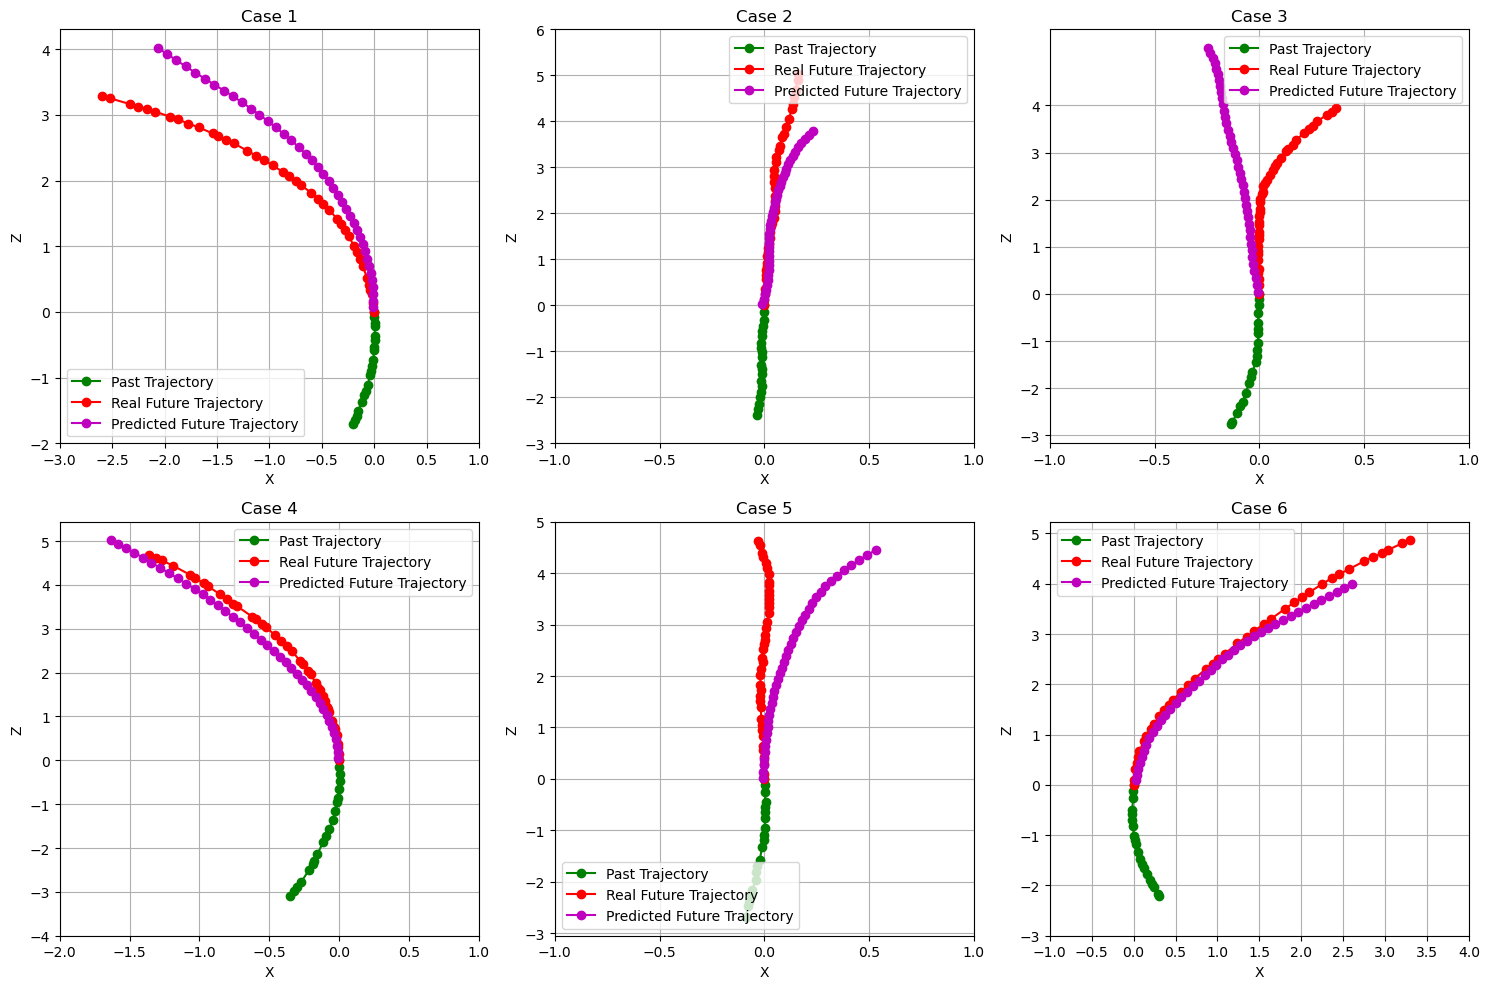

Autoregressive model performances on train set:

ADE Total = 0.187259,   ADE X = 0.107576,   ADE Z = 0.127561
FDE Total = 0.378648,   FDE X = 0.251573,   FDE Z = 0.224323

Autoregressive model performances on test set:

ADE Total = 0.364530,   ADE X = 0.210129,   ADE Z = 0.254115
FDE Total = 0.813930,   FDE X = 0.549240,   FDE Z = 0.494059


In [26]:
# Evaluation del modello autoregressivo (plot traiettorie + calcolo metriche)

print("Evaluating autoregressive model trajectories:")
evaluate_trajectories(autoregressive_model, device, test_loader)
performance_measurement(autoregressive_model, device, train_loader, test_loader, label="Autoregressive")

In [16]:
# Istanzia il modello one shot e ne carica i pesi

one_shot_model = OneShotModel(class_to_emb_idx=class_to_emb_idx, embedding_dim=embedding_dim,
                              input_size=input_size, hidden_size=hidden_size, 
                              output_size=input_size*future_seconds*framerate, num_layers=num_layers, 
                              future_steps=future_seconds*framerate).to(device)

one_shot_model.load_state_dict(torch.load("pred_from_past_and_pc_sem_oneshot_model"))

one_shot_model.eval()

OneShotModel(
  (embedding_layer): Embedding(59, 32)
  (pointnet): PointNetfeat(
    (conv1): Conv1d(35, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pc_emb_proj): Linear(in_features=1024, out_features=128, bias=True)
  (pc_emb_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (gru): GRU(2, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=80, bias=True)
)

Evaluating one shot model trajectories:


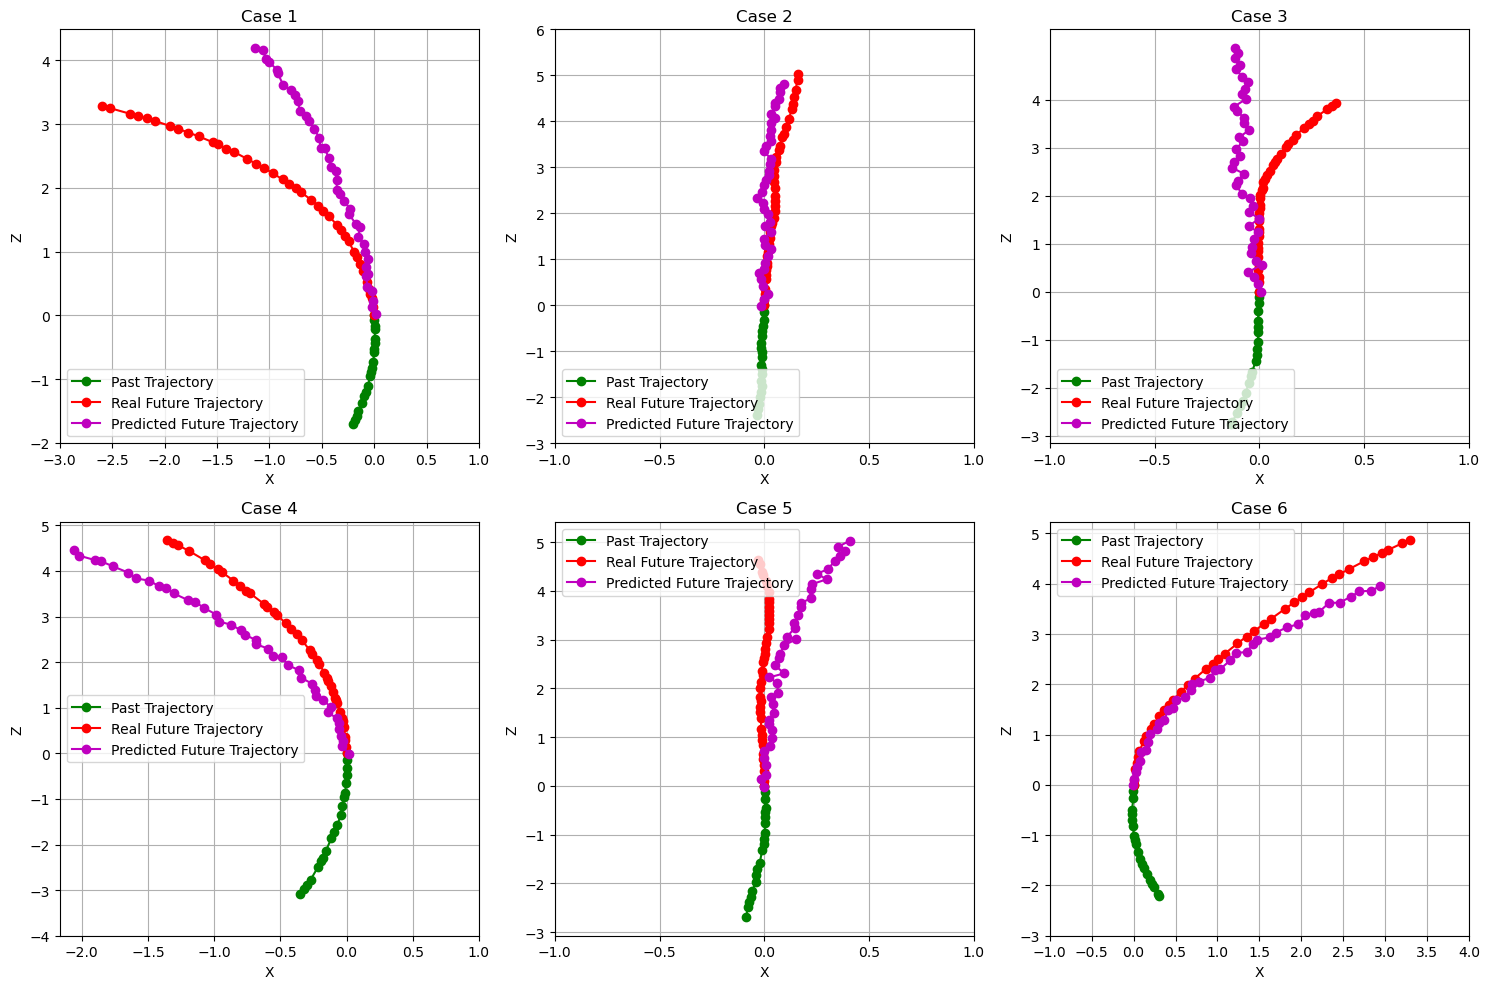

One shot model performances on train set:

ADE Total = 0.340468,   ADE X = 0.179927,   ADE Z = 0.246720
FDE Total = 0.719945,   FDE X = 0.458726,   FDE Z = 0.456837

One shot model performances on test set:

ADE Total = 0.368537,   ADE X = 0.206474,   ADE Z = 0.256299
FDE Total = 0.813629,   FDE X = 0.531817,   FDE Z = 0.491811


In [22]:
# Evaluation del modello one shot (plot traiettorie + calcolo metriche)

print("Evaluating one shot model trajectories:")
evaluate_trajectories(one_shot_model, device, test_loader)

performance_measurement(one_shot_model, device, train_loader, test_loader, label="One shot")